In [3]:
import copy
import math
import numpy as np
from sympy import *
from sympy.solvers import solve
import matplotlib.pyplot as plt
from scipy.integrate import ode

In [4]:
d = 0.8
l = 1
X1 = 3.6
X2 = 0
Y1 = 0.8
Y2 = -2.4
mu1 = 0.525
mu2 = 2.85

In [5]:
x10 = 0
dx10 = 10
x20 = -0.65
dx20 = 10
ddelta0 = 0
delta0 = 0.03

In [6]:
eps = 0.1
k = 1
nu = 1

In [7]:
# Obtain equilibrium positions of system and check their stability

def get_equilibriums(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d):
    phi0 = math.acos((x10 - x20) / l)
    Xs_n = (X1 - X2) / math.cos(phi0)
    Y1s_n = Y1 / math.sin(phi0)
    Y2s_n = Y2 / math.sin(phi0)
    mu1s_n = mu1 * math.tan(phi0)
    mu2s_n = mu2 * math.tan(phi0)
    
    if dx10 == 0:
        return None
    sigma1_n = np.sign(dx10)

    if dx20 == 0:
        return None
    sigma2_n = np.sign(dx20)
    
    R, mu1s, mu2s, Y1s, Y2s, sigma1, sigma2 = symbols('R, mu_1^*, mu_2^*, Y_1^*, Y_2^*, sigma1, sigma2', \
                                                      real = True)
    
    def get_Phi(mu1s_num, mu2s_num, Y1s_num, Y2s_num, sigma1_num, sigma2_num):
        return (2 * R + sigma1 * mu1s * abs(R - Y1s) - sigma2 * mu2s * abs(R + Y2s))\
                .subs(mu1s, mu1s_num).subs(mu2s, mu2s_num)\
                .subs(Y1s, Y1s_num).subs(Y2s, Y2s_num)\
                .subs(sigma1, sigma1_num).subs(sigma2, sigma2_num)
    
    Phi = get_Phi(mu1s_n, mu2s_n, Y1s_n, Y2s_n, sigma1_n, sigma2_n)
    
    ans = []
    R_roots = list(solve(Phi - Xs_n, R, check = False))
    
    for R_root in R_roots:
        var = (2 + np.sign(R_root - Y1s_n) * sigma1_n * mu1s_n - np.sign(R_root + Y2s_n) * sigma2_n * mu2s_n)
        
        eig, _ = np.linalg.eig([[- math.cos(phi0) * math.cos(phi0) * var * nu / eps,\
                   - math.cos(phi0) * math.cos(phi0) * var * k / eps / eps],\
                   [1, 0]])
        
        if np.all(np.real(eig) < 0) == True:
            ans.append([R_root * eps * eps / k, 'Stable'])
        else:
            ans.append([R_root * eps * eps / k, 'Unstable'])
            
    return ans

In [8]:
get_equilibriums(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d)

[[0.0280999326169016, 'Stable'], [0.0604052248713859, 'Unstable']]

In [9]:
# Get phase portrait of linearized system

def get_phase_linear(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20,\
                     l, d, delta0, ddelta0, t_0, t_N, t_step):
    phi0 = math.acos((x10 - x20) / l)
    Xs_n = (X1 - X2) / math.cos(phi0)
    Y1s_n = Y1 / math.sin(phi0)
    Y2s_n = Y2 / math.sin(phi0)
    mu1s_n = mu1 * math.tan(phi0)
    mu2s_n = mu2 * math.tan(phi0)
    
    if dx10 == 0:
        return None
    sigma1_n = np.sign(dx10)

    if dx20 == 0:
        return None
    sigma2_n = np.sign(dx20)

    def right_part(x, y):
        R = k * y[1] / eps / eps + nu * y[0] / eps
        P = 2 * R + sigma1_n * mu1s_n * abs(R - Y1s_n) - sigma2_n * mu2s_n * abs(R + Y2s_n)
    
        return [math.cos(phi0) * math.cos(phi0) * (Xs_n - P), y[0]]
    
    integr = ode(right_part).set_integrator('dopri5')
    integr.set_initial_value([ddelta0, delta0], t_0)
    
    traj_ans = [np.array(initial_value) 
                    for initial_value in [ddelta0, delta0]]
    
    R_ans = np.array(k * delta0 / eps / eps + nu * ddelta0 / eps)
    t_ans = np.array(t_0)

    while integr.successful() and integr.t < t_N:
        integr.integrate(integr.t + t_step)

        traj_ans = [np.append(traj_ans[i], [integr.y[i]]) for i in range(len(integr.y))]
        R_ans = np.append(R_ans, k * integr.y[1] / eps / eps + nu * integr.y[0] / eps)
        t_ans = np.append(t_ans, integr.t)
            
    plt.plot(traj_ans[1], traj_ans[0])
    plt.xlabel('delta')
    plt.ylabel('ddelta')
    plt.show()
    plt.plot(t_ans, R_ans)
    plt.xlabel('t')
    plt.ylabel('R')
    plt.show()

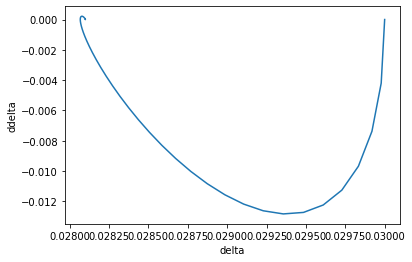

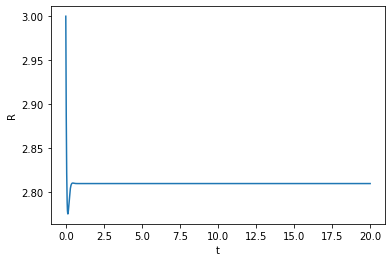

In [10]:
# Near stable equilibrium point
get_phase_linear(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d, 0.03, 0, 0, 20, 0.01)

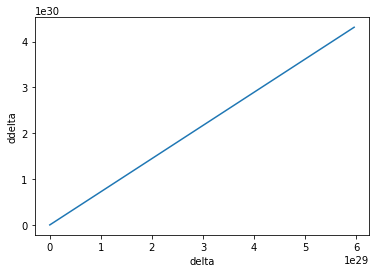

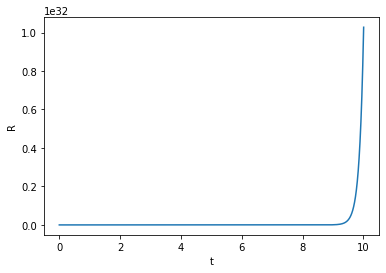

In [13]:
# Near unstable equilibrium point
get_phase_linear(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d, 0.12, 0, 0, 10, 0.01)

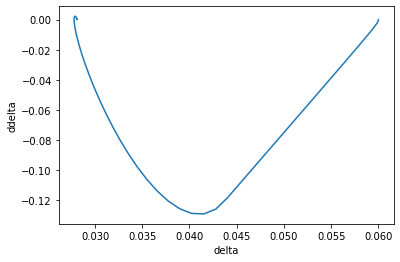

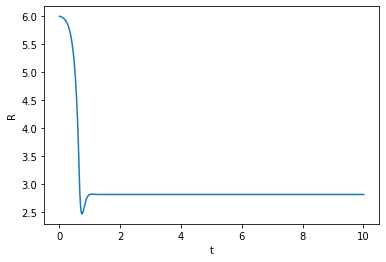

In [14]:
# Far from stable equilibrium point
get_phase_linear(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d, 0.06, 0, 0, 10, 0.01)

In [23]:
# Get phase portrait of system, checking sticking in process

def get_phase(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20,\
              l, d, delta0, ddelta0, t_0, t_N, t_step):
    
    prev_dx1_sign = np.sign(dx10)
    prev_dx2_sign = np.sign(dx20)
    
    if dx10 == 0:
        return None
    sigma1_n = np.sign(dx10)

    if dx20 == 0:
        return None
    sigma2_n = np.sign(dx20)

    def right_part(x, y):
        global prev_dx1_sign
        global prev_dx2_sign

        phi = math.asin(d / (l + y[1]))
        R = k * y[1] / eps / eps + nu * y[0] / eps
        sigma1_n = np.sign(y[2])
        sigma2_n = np.sign(y[4])

        is_dx1_zero = (prev_dx1_sign != np.sign(y[2])) or abs(y[2]) < 0.0001
        is_dx2_zero = (prev_dx2_sign != np.sign(y[4])) or abs(y[4]) < 0.0001
    
        prev_dx1_sign = np.sign(y[2])
        prev_dx2_sign = np.sign(y[4])
        
        is_cond1 = (abs(X1 - R * math.cos(phi)) <= mu1 * abs(Y1 - R * math.sin(phi)))
        is_cond2 = (abs(X2 + R * math.cos(phi)) <= mu2 * abs(Y2 + R * math.sin(phi)))
        
        if is_dx1_zero and is_dx2_zero and is_cond1 and is_cond2:
            return [math.tan(phi) * math.tan(phi) * y[0] * y[0] / (l + y[1]), \
                y[0],
               0,
               y[2],
               0,
               y[4]]
        
        if is_dx1_zero and is_cond1:
            return [math.tan(phi) * math.tan(phi) * y[0] * y[0] / (l + y[1]) + \
                math.cos(phi) * (- X2 - R * math.cos(phi) + sigma2_n * mu2 * abs(Y2 + R * math.sin(phi))), \
                y[0],
               0,
               y[2],
               X2 + R * math.cos(phi) - sigma2_n * mu2 * abs(Y2 + R * math.sin(phi)),
               y[4]]
        
        if is_dx2_zero and is_cond2:
            return [math.tan(phi) * math.tan(phi) * y[0] * y[0] / (l + y[1]) + \
                math.cos(phi) * (X1 - R * math.cos(phi) - sigma1_n * mu1 * abs(Y1 - R * math.sin(phi))), \
                y[0],
               X1 - R * math.cos(phi) - sigma1_n * mu1 * abs(Y1 - R * math.sin(phi)),
               y[2],
               0,
               y[4]]
            
        return [math.tan(phi) * math.tan(phi) * y[0] * y[0] / (l + y[1]) + \
                math.cos(phi) * (X1 - X2 - 2 * R * math.cos(phi) - (sigma1_n * mu1 * abs(Y1 - R * math.sin(phi)) - \
                                                                   sigma2_n * mu2 * abs(Y2 + R * math.sin(phi)))), \
                y[0],
               X1 - R * math.cos(phi) - sigma1_n * mu1 * abs(Y1 - R * math.sin(phi)),
               y[2],
               X2 + R * math.cos(phi) - sigma2_n * mu2 * abs(Y2 + R * math.sin(phi)),
               y[4]]
    
    integr = ode(right_part).set_integrator('dopri5')
    integr.set_initial_value([ddelta0, delta0, dx10, x10, dx20, x20], t_0)
    
    traj_ans = [np.array(initial_value) 
                    for initial_value in [ddelta0, delta0, dx10, x10, dx20, x20]]
    
    R_ans = np.array(k * delta0 / eps / eps + nu * ddelta0 / eps)
    t_ans = np.array(t_0)

    while integr.successful() and integr.t < t_N:
        integr.integrate(integr.t + t_step)

        traj_ans = [np.append(traj_ans[i], [integr.y[i]]) for i in range(len(integr.y))]
        R_ans = np.append(R_ans, k * integr.y[1] / eps / eps + nu * integr.y[0] / eps)
        t_ans = np.append(t_ans, integr.t)
            
    plt.plot(traj_ans[1], traj_ans[0])
    plt.xlabel('delta')
    plt.ylabel('ddelta')
    plt.show()
    plt.plot(t_ans, R_ans)
    plt.xlabel('t')
    plt.ylabel('R')
    plt.show()
    plt.plot(t_ans, traj_ans[2])
    plt.xlabel('t')
    plt.ylabel('dx1')
    plt.show()
    plt.plot(t_ans, traj_ans[4])
    plt.xlabel('t')
    plt.ylabel('dx2')
    plt.show()

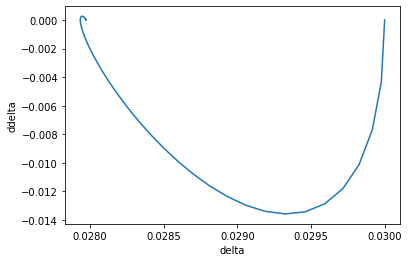

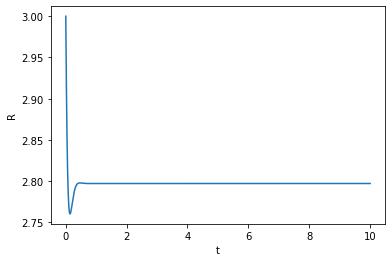

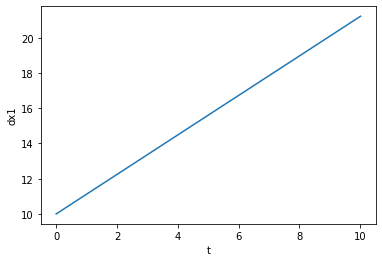

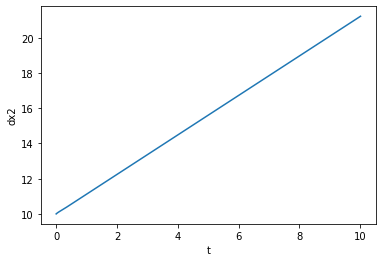

In [24]:
# Near stable equilibrium point

prev_dx1_sign = np.sign(dx10)
prev_dx2_sign = np.sign(dx20)
    
get_phase(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d, 0.03, 0, 0, 10, 0.01)

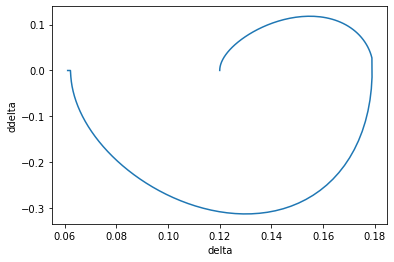

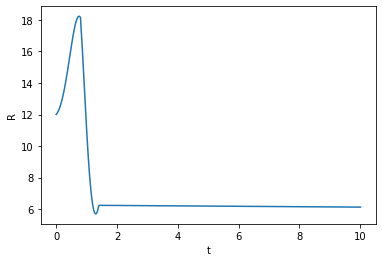

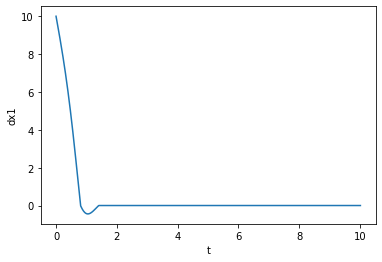

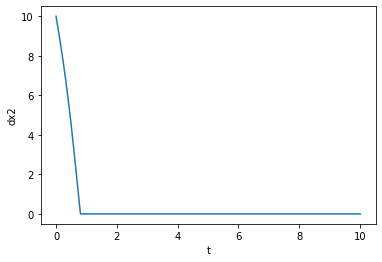

In [26]:
# Far from stable equilibrium point

prev_dx1_sign = np.sign(dx10)
prev_dx2_sign = np.sign(dx20)

get_phase(X1, X2, Y1, Y2, mu1, mu2, eps, k, nu, x10, x20, dx10, dx20, l, d, 0.12, 0, 0, 10, 0.01)